In [1]:
#alguns imports

import sys
import os

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pyspark.sql.functions as psf
from pyspark.sql.types import *

from pyspark.ml import Pipeline
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import Imputer, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")


VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1653555538444_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:

#criar uma instância SparkSession

#spark = SparkSession\
    #.builder\
    #.appName("Dataset")\
    #.config("spark.sql.shuffle.partitions",6)\
    #.config("spark.sql.repl.eagerEval.enabled", True)\
    #.getOrCreate()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:

#Leitura do dataset
df_raw = spark.read.csv("s3://bigdatanoaa/Dataset/", header="false", inferSchema="true", sep=",")   
#Renomear as colunas
df_raw = df_raw.toDF("ID", "DATE", "ELEMENT", "DATA VALUE", "MFLAG", "QFLAG", "SFLAG", "OBS_TIME")  

#Leitura do ficheiro de dados relativo aos países
df_countries = spark.read.csv("s3://bigdatanoaa/ghcnd-countries.csv", header="false", inferSchema="true", sep=";")
#Renomear as colunas
df_countries = df_countries.toDF("CÓDIGO","PAÍS","CONTINENTE")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [4]:

#colunas irrelevantes
cols_to_drop = ['MFLAG', 'QFLAG', 'SFLAG', 'OBS_TIME']

#colunas de interesse
cols_interest = [x for x in df_raw.columns if x not in cols_to_drop]

#eliminação das colunas irrelevantes
df_raw_interest = df_raw.select(cols_interest)


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:

# Os valores correspondentes às temperaturas e preciciptação apresentam inicialmente um formato de tenth of degrees
# É preciso dividir esses valores por 10 de modo a obter o valor em graus centígrados

df_raw_interest = df_raw_interest.withColumn("DATA VALUE",
    when((col("ELEMENT") == "TMAX")|(col("ELEMENT") == "TMIN")|(col("ELEMENT") == "TAVG")|(col("ELEMENT") == "PRCP"),
    round((col("DATA VALUE")/10),2)).otherwise(col("DATA VALUE")))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [6]:

#Junção dos dados com o ficheiro que contém o código e o nome dos países
join_data = df_raw_interest.join(df_countries).where(col("ID").substr(1,2) == df_countries["CÓDIGO"]).drop(df_raw["ID"])

#Filtramos apenas a temperatura média
df_raw2 = join_data.filter(col("ELEMENT") == "TAVG")

#Passagem das datas para forma de data de modo a conseguirmos comparar as datas
new_data = df_raw2.withColumn("DATE",to_date(col("DATE").cast(StringType()),"yyyyMMdd"))


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:

#Apresentação do resultado que representa o valor de temperatura média em todo o mundo
#durante os anos disponíveis no nosso dataset, ou seja, entre os anos 1763 e 2022
df_raw2.select(avg("DATA VALUE")).show()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|  avg(DATA VALUE)|
+-----------------+
|9.616642640843063|
+-----------------+

In [8]:

#Filtragem de modo a obter todas as observações registadas entre os anos 2000 e 2021
df_real = new_data.filter((year(col("DATE"))>=2000) & (year(col("DATE"))<2022))

#Agrupação de modo a obter os valores de temperatura média para cada continente
df_real2 = df_real.groupBy("CONTINENTE",year(col("DATE"))).avg("DATA VALUE")

#Renomear as colunas
df_real3 = df_real2.toDF("CONTINENTE","ANO","TAVG")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [9]:

#Passagem do tipo do ano para String de modo a facilitar a observação do gráfico
df_real4 = df_real3.withColumn("ANO",col("ANO").cast(StringType()))

#Ordenação por ordem crescente de ano
df_region = df_real4.orderBy("ANO",ascending=True).toPandas()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

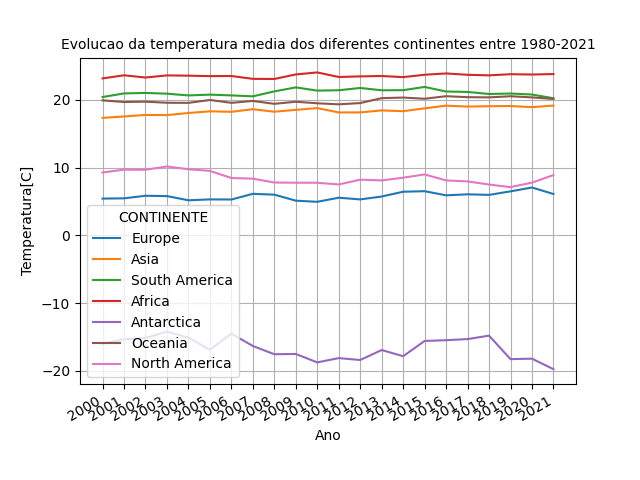

In [10]:

#São feitos os imports novamente de modo a permitir a visualização do gráfico
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns


#Construção do gráfico de Evolução da temperatura média dos diferentes continentes entre 1980-2021
plt.plot(figsize=(40,12))
sns.lineplot(y="TAVG",x="ANO",data=df_region,hue="CONTINENTE")
plt.xlabel('Ano')
plt.ylabel('Temperatura[C]')
plt.title('Evolucao da temperatura media dos diferentes continentes entre 1980-2021',fontsize=10)
plt.gcf().autofmt_xdate()
plt.grid()
plt.show()

#Comando local para permitir a visualização do gráfico
%matplot plt


In [11]:
#Construção de um modelo de regressão linear para prever temperaturas

#Substituição da coluna que contém as datas pelo seu ano respetivo
#modelo = new_data.withColumn("DATE",year(col("DATE")))

#Renomeação de colunas
#modelo = modelo.toDF("ANO","ELEMENT","DATA VALUE", "CÓDIGO", "PAÍS", "CONTINENTE")

#Construção do vetor assembler
#assembler = VectorAssembler(inputCols=["ANO"],outputCol="features")
#vec_assembler = assembler.transform(modelo)

#Os dados obtidos para o continente Europeu são separados em dois grupos de forma aleatória
#df_train, df_test = vec_assembler.randomSplit([0.8, 0.2],seed=42)

#Construção do modelo de Regressão Linear
#lr = LinearRegression(featuresCol="features", labelCol="DATA VALUE")
#lr_model = lr.fit(df_train)

#É criada uma nova colunas com os valores previstos
#predictions = model.transform(df_test)

#Retorno do número de linhas da parte de treino e da parte de teste
#print(f"Existem {df_train.count()} linhas no training set e {df_test.count()} no test set")


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [12]:

#Ordenação dos valore reais por ordem crescente de ano
#df_real = predictions.filter(col("CONTINENTE") == "Europe")
#df_real_plot = df_real.groupBy("ANO").avg("DATA VALUE")
#df_real_plot = df_real_plot.orderBy("ANO",ascending=True).toPandas()

#Ordenação dos valore previstos por ordem crescente de ano
#df_predict = predictions.filter(col("CONTINENTE") == "Europe")
#df_predict_plot = df_predict.groupBy("ANO").avg("prediction")
#df_predict_plot = df_predict_plot.orderBy("ANO",ascending=True).toPandas()

#Construção do gráfico da evolução da temperatura média na Europa entre 2000 e 2010
#plt.plot(df_real_plot["ANO"],df_real_plot["avg(DATA VALUE)"], color='b', label= 'Valores registados')
#plt.plot(df_predict_plot["ANO"],df_predict_plot["avg(prediction)"], color = 'r',label = 'Valores previstos')
#plt.xlabel('ANOS')
#plt.ylabel('TEMPERATURA MÉDIA [°C]')
#plt.title('Evolução da temperatura média na Europa entre 2000-2010');
#plt.legend()


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…